In [ ]:
# This going to be a Jupyter based note on estimating risk in cybersecurity.
# After reading "How to measure anything in cybersecurity" Chapters 3-4 by D. Hubbard and R. Seiersen.
# two input files: events_losses.csv, sec_controls.csv and risk_tolerance.csv
# output: loss exceedance curves vs risk tolerance curve.

In [81]:
import pandas as pd
df = pd.read_csv('events_losses.csv')
df.head()

,events,probability,lb_loss,ub_loss,description
0,event1,0.21,100000,550000,Successful DDoS on the cloud base core app
1,event2,0.08,500000,1500000,Sensitive data exfiltration
2,event3,0.15,200000,1000000,Malicious code injected into production pipeline
3,event4,0.38,10000,100000,Laptop with sensitive data lost/stolen
4,event5,0.17,15000,50000,Malicious code in 3rd party dependencies


In [196]:
df_sec = pd.read_csv('sec_controls.csv')
df_sec['no_mit'] = 0
df_sec.head()

,events,cost,mitigation,no_mit
0,event1,70000,0.65,0
1,event2,200000,0.55,0
2,event3,77000,0.70,0
3,event4,30000,0.37,0
4,event5,25000,0.42,0


In [197]:
df_rt = pd.read_csv('risk_tolerance.csv')
df_rt.head()

,amount,probability
0,100000,0.90
1,250000,0.50
2,500000,0.30
3,750000,0.15
4,1000000,0.02


In [152]:
# simulation parameters

STEP = 5000
NO_SIMULATIONS = 10000

In [153]:
### computing functions

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [154]:
# This function takes P of a threat event from df and mitigating control reducing P by some number from (0,1)
# and if the random number falls under computed P, it takes True else False.

def threat_event_happened(event_p, reduct_p):
    """A threat event occurs if a random number
    falls below given probability"""
    return np.random.rand() < event_p*(1-reduct_p)

def threat_event_loss(lower_bnd, upper_bnd):
    """If threat event occured, let's get its loss it inflicts,
    given lower and upper bounds of 90% CI"""
    mean = (np.log(lower_bnd) + np.log(upper_bnd))/2
    std_deviation = (np.log(upper_bnd) - np.log(lower_bnd))/3.29
    return round(float(np.random.lognormal(mean, std_deviation)),2)

df_k = pd.DataFrame(columns = ['tests'])
df_l = pd.DataFrame(columns = ['total_loss'],['total_loss_no_mit'])

In [155]:
# Let's compute total loss per each iteration, when loss = 0 if threat event did not happen given its P and mitigating P
loss_list = []
for i in range(NO_SIMULATIONS):
    df_k['tests'] = [threat_event_happened(ep,rp) for ep, rp in zip(df['probability'],df_sec['mitigation'])] # compute P of event
    r,c = np.where(df_k == True) # take the positions of all these elements where event occured giving True
    if r.size>0: # for these positions take LB and UB and compute loss amount
        threat_loss = sum([threat_event_loss(df.iloc[x,2], df.iloc[x,3]) for x in r])
    else: 
        threat_loss = 0
    loss_list.append(threat_loss) # append total loss in this iteration for all 10 events (whichever of them happened)
df_l['total_loss'] = loss_list # create a data frame of loss occurence across the iterations

In [200]:
# let's compute total loss per each iteration, with no mitigating control
loss_list = []
for i in range(NO_SIMULATIONS):
    df_k['tests'] = [threat_event_happened(ep,rp) for ep, rp in zip(df['probability'],df_sec['no_mit'])] # compute P of event
    r,c = np.where(df_k == True) # take the positions of all these elements where event occured giving True
    if r.size>0: # for these positions take LB and UB and compute loss amount
        threat_loss = sum([threat_event_loss(df.iloc[x,2], df.iloc[x,3]) for x in r])
    else: 
        threat_loss = 0
    loss_list.append(threat_loss) # append total loss in this iteration for all 10 events (whichever of them happened)
df_l['total_loss_no_mit'] = loss_list # create a data frame of loss occurence across the iterations

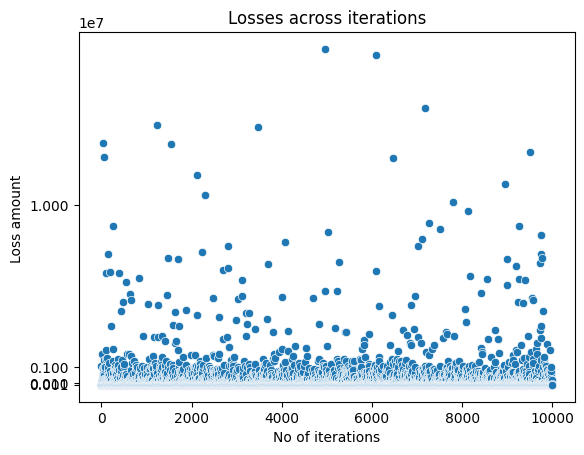

In [201]:
# Plot losses across iterations - w/ mitigation controls

ax.set_ylim(0,12000000)
plt.yticks([10000, 100000,1000000,10000000])
ax = sns.scatterplot(df_l['total_loss'])
ax.set(xlabel='No of iterations', ylabel='Loss amount ', title='Losses across iterations')
plt.show()

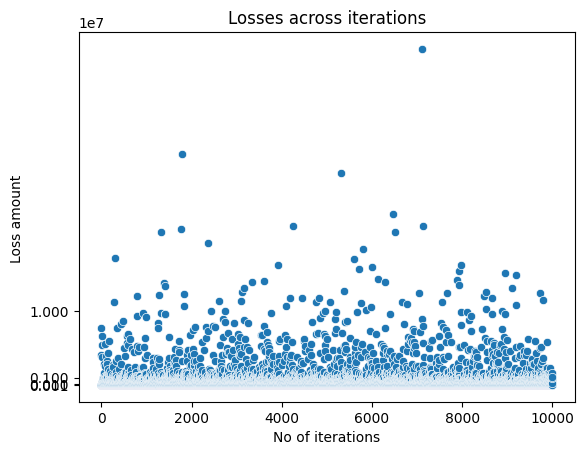

In [202]:
# plot losses w/o mitigating controls
ax.set_ylim(0,12000000)
plt.yticks([10000, 100000,1000000,10000000])
ax = sns.scatterplot(df_l['total_loss_no_mit'])
ax.set(xlabel='No of iterations', ylabel='Loss amount ', title='Losses across iterations')
plt.show()

In [159]:
def loss_average(lst):
    """ This one is simple, I guess"""
    return round(np.mean(lst),2)

loss_average(df_l['total_loss'])

172838.57

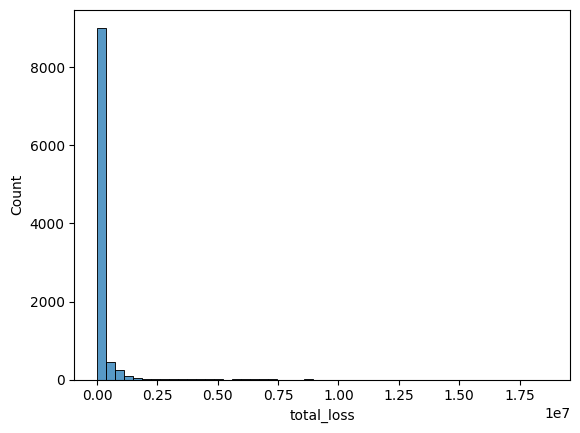

In [186]:
# Aggregate losses and show histogram
sns.histplot(df_l['total_loss'], bins=50)
plt.show()

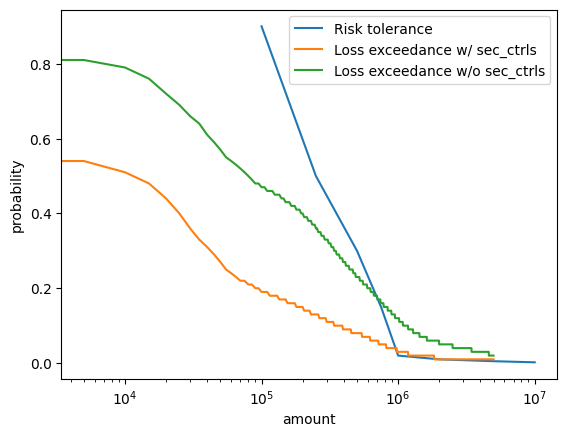

In [203]:
# plot loss exceedance curve vs risk tolerance with a function which computes the set from total_loss dataframe

def loss_exceedance_curve(lst, STEP):
    """ Compute a list of LEC to see how good we are in terms of
    probability and magnitude of losses"""
    loss_ex_lst = []
    for x in range(0,5000000,STEP):
        accu = 0
        for loss in lst:
            if loss > 0 and loss > x: 
                accu += 1
        loss_ex_lst.append([x,round(accu/len(lst),2)])
    return loss_ex_lst

df_lel = pd.DataFrame(columns=['amount','probability'])
df_lel[['amount','probability']] = loss_exceedance_curve(df_l['total_loss'], STEP)
df_lel[['amount_nm','probability_nm']] = loss_exceedance_curve(df_l['total_loss_no_mit'], STEP)

ax = plt.subplot()
sns.lineplot(x=df_rt['amount'],y=df_rt['probability'], label='Risk tolerance')
sns.lineplot(x=df_lel['amount'],y=df_lel['probability'], label='Loss exceedance w/ sec_ctrls')
sns.lineplot(x=df_lel['amount_nm'],y=df_lel['probability_nm'], label='Loss exceedance w/o sec_ctrls')
plt.xscale('log')
plt.show()

In [192]:
# Obtain 5% Value at Risk - 4 745 250 Euro
np.percentile(df_lel['amount'],95)

4745250.0

In [193]:
# Obtain average VaR under the 5%
np.average(df_lel['amount'][df_lel['amount'] > np.percentile(df_lel['amount'],95)])

4872500.0